Now we will train the High Level Feature classifier.

To run this notebook we used the following configuration:
* *Software stack*: LCG 94 (it has spark 2.3.1)
* *Platform*: centos7-gcc7
* *Spark cluster*: Hadalytic

In [1]:
# Check if Spark Session has been created correctly
spark

In [2]:
# Add the BDL zip file
#sc.addPyFile("/eos/project/s/swan/public/BigDL/bigdl-0.7.0-python-api.zip")

## Load train and test dataset

In [3]:
PATH = "file:///data/cern/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])

In [4]:
trainDF.printSchema()

root
 |-- HLF_input: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)



In [5]:
trainDF.count()

8611

## Create the model

In [6]:
# Init analytics zoo
from zoo.common.nncontext import *
sc = init_nncontext("hlf classifier")

In [7]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [8]:
# Create tensorflow keras model.
# Only need to change package name from keras to zoo.pipeline.api.keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from zoo.tfpark import KerasModel, TFDataset

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

model = create_model(50,20,10)

## Create train and valiation RDD



In [9]:
# Let's have a look at one element of trainDF
trainDF.show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|HLF_input                                                                                                                                                                                                |encoded_label|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|[0.010696109580467801,0.03581727369726868,0.6577833047712135,0.0020216866244454996,0.07692307692307693,0.0,0.00600872373025112,0.6999402220930278,0.29771337282431887,0.7611435535579052,0.0,0.0,0.0,0.0]|(3,[0],[1.0])|
+-------------------------------------------------------------------------------------------------------------------------------

In [10]:
# from bigdl.util.common import Sample
import numpy as np

trainRDD = trainDF.rdd.map(lambda row: (np.array(row.HLF_input),
    np.array(row.encoded_label))
)

testRDD = testDF.rdd.map(lambda row: (np.array(row.HLF_input),
    np.array(row.encoded_label))
)


We can see the 14 high level features (`shape=[14]`) and the encoded label (`shape=[3]`).

In [11]:
# The batch used by BDL must be a multiple of numExecutors * executorCores
# Because data will be equally distibuted inside each executor

workerBatch = 50
# numExecutors = int(sc._conf.get('spark.executor.instances'))
numExecutors = 1
# executorCores = int(sc._conf.get('spark.executor.cores'))
executorCores = 4

BDLbatch = workerBatch * numExecutors * executorCores

In [12]:
import tensorflow as tf
# create TFDataset for TF training
dataset = TFDataset.from_rdd(trainRDD,
                                 features=(tf.float32, [14]),
                                 labels=(tf.float32, [3]),
                                 batch_size=128,
                                 val_rdd=testRDD)

## Estimator setup and training

In [13]:
# Set of hyperparameters
numEpochs = 5

In [14]:
# Create SparkML compatible estimator for deep learning training

from bigdl.optim.optimizer import EveryEpoch, Loss, TrainSummary, ValidationSummary
from zoo.pipeline.nnframes import *
from zoo.pipeline.api.keras.objectives import CategoricalCrossEntropy

# Use Keras model training API to train

from bigdl.optim.optimizer import *
from bigdl.nn.criterion import CategoricalCrossEntropy

model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

keras_model = KerasModel(model)
# estimator = NNEstimator(model, CategoricalCrossEntropy())\
#         .setOptimMethod(Adam()) \
#         .setBatchSize(BDLbatch) \
#         .setMaxEpoch(numEpochs) \
#         .setFeaturesCol("HLF_input") \
#         .setLabelCol("encoded_label") \
#         .setValidation(trigger=EveryEpoch() , val_df=testDF,
#                        val_method=[Loss(CategoricalCrossEntropy())], batch_size=BDLbatch)

Let's define a directory to store logs (i.e. train and validation losses) and save models

In [15]:
# name of our application
appName = "HLFclassifier"

# Change it! 
logDir = "/data/cern/ZOOlogs"

# Check if there is already an application with the same name 
# and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

Saving logs to /data/cern/ZOOlogs/HLFclassifier


In [16]:
# Set tensorboard for model training and validation

trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
keras_model.set_train_summary(trainSummary)
keras_model.set_val_summary(valSummary)

creating: createTrainSummary
creating: createValidationSummary


We are now ready to launch the training.

Warnign: During the trainign it would be better to shutdown the Toggle Spark Monitorin Display because each iteration is seen as a spark job, therefore the toggle will try to display everything causing problem to the browser. 

In [17]:
%%time 
keras_model.fit(dataset,
                    epochs=numEpochs,
                    distributed=True)

AttributeError: 'Sequential' object has no attribute 'targets'

## Plot loss

<IPython.core.display.Javascript object>


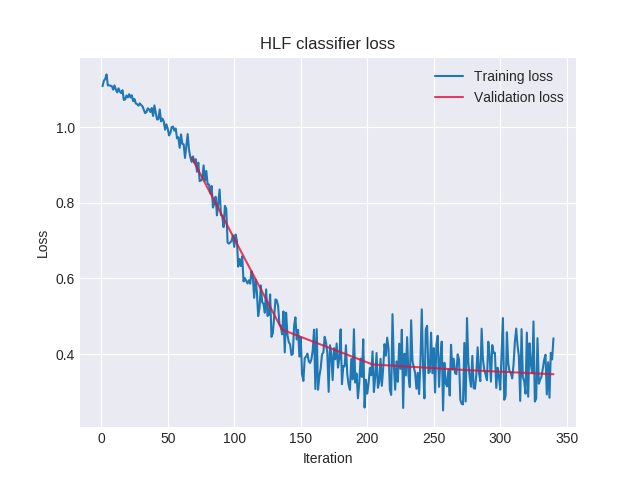

In [45]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

loss = np.array(trainSummary.read_scalar("Loss"))
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("HLF classifier loss")
plt.show()

## Save the model

In [46]:
modelDir = os.path.join(logDir, "models", "hlf.model")
keras_model.save_model(modelDir)

It is possible to load the model in the following way:
```Python
model = NNModel.load(path=modelDir)
```
The default feature column name is "features", if your feature column is different, set feature column with this way:
```
model = model.setFeaturesCol("HLF_input")
```

## Prediction

In [47]:
testRDD2 = testDF.rdd.map(lambda row: np.array(row.HLF_input))
    
test_dataset = TFDataset.from_rdd(testRDD2,
                                 features=(tf.float32, [14]),
                                 labels=None,
                                 batch_per_thread=128)

In [48]:
# Predict with trained NNModel using pipeline transform API
predRDD = keras_model.predict(test_dataset)

creating: createTFNet


In [49]:
result = predRDD.collect()

In [50]:
result

[array([0.11477491, 0.00582443, 0.8794007 ], dtype=float32),
 array([0.04703783, 0.00624609, 0.94671607], dtype=float32),
 array([0.95778996, 0.00459217, 0.03761784], dtype=float32),
 array([0.92853415, 0.00772948, 0.06373639], dtype=float32),
 array([0.810068  , 0.00869552, 0.18123652], dtype=float32),
 array([0.28142643, 0.01650856, 0.70206505], dtype=float32),
 array([0.6966514 , 0.00597175, 0.29737687], dtype=float32),
 array([0.5590718 , 0.00449102, 0.4364372 ], dtype=float32),
 array([0.60673153, 0.00551654, 0.3877519 ], dtype=float32),
 array([0.02479113, 0.00459087, 0.970618  ], dtype=float32),
 array([0.5413008 , 0.01162543, 0.44707385], dtype=float32),
 array([0.5828396 , 0.00707183, 0.41008857], dtype=float32),
 array([0.3038418 , 0.01068048, 0.68547773], dtype=float32),
 array([0.83408666, 0.00145969, 0.16445374], dtype=float32),
 array([0.8343039 , 0.00696047, 0.15873556], dtype=float32),
 array([0.6940612 , 0.00544057, 0.30049822], dtype=float32),
 array([0.31330064, 0.00

In [51]:
y_pred = result
y_true = np.asarray(testDF.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [52]:
y_pred = np.squeeze(y_pred)
y_pred.shape

(2123, 3)

In [53]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


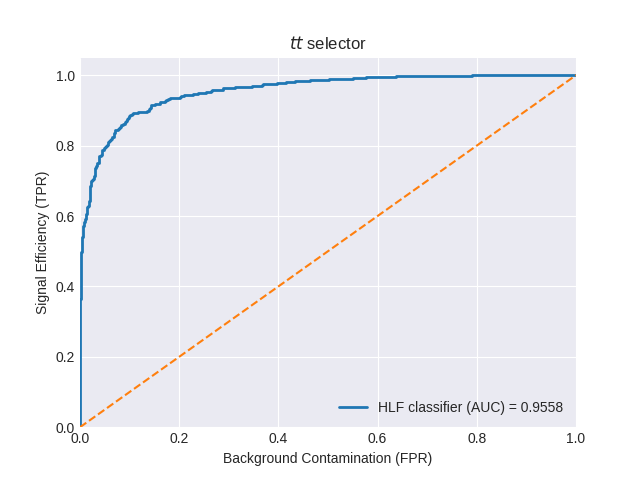

In [54]:
plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()